In [52]:
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy_lefff import LefffLemmatizer, POSTagger
import json

import numpy as np


from spacy.util import minibatch, compounding
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sn

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import matplotlib.pyplot as plt



In [72]:
def load_json_data(filename: str) -> dict:
    """
    Load the content of the json file as a dict.
    """
    f = open(filename, 'r')
    file_content = json.load(f)
    f.close()
    return file_content


def get_raw_training_data(path: str = './training_set.json'):
    """
    Load the raw training set.
    """
    return load_json_data(path)


def get_raw_testing_data(path: str = './testing_set.json'):
    """
    Load the raw testing set.
    """
    return load_json_data(path)

def get_labels():
    #raw_training_data = get_raw_training_data()
    #return list(set([v['intent'] for v in raw_training_data]))
    return ['find-train',
            'irrelevant',
            'find-flight',
            'find-restaurant',
            'purchase',
            'find-around-me',
            'provide-showtimes',
            'find-hotel'
           ]

In [54]:
def format_data(data):

    texts = [td['sentence'] for td in data]
    labels = [td['intent'] for td in data]

    cats = [{'find-around-me': y == 'find-around-me',
             'purchase': y == 'purchase',
             'find-hotel': y == 'find-hotel',
             'provide-showtimes': y == 'provide-showtimes',
             'irrelevant': y == 'irrelevant',
             'find-train': y == 'find-train',
             'find-flight': y == 'find-flight',
             'find-restaurant': y == 'find-restaurant'} for y in labels]
    

    return texts, cats

In [55]:
def get_spacy_model():

    nlp = spacy.load('fr_core_news_sm')

    textcat=nlp.create_pipe("textcat", config={"exclusive_classes": True, "architecture": "ensemble"})
    nlp.add_pipe(textcat, last=True)

    for label in get_labels():
        textcat.add_label(label)
    
    return nlp

In [56]:
def train(model, X, y, n_iter=10):

    train_data = list(zip(X, [{"cats": cats} for cats in y]))

    # get names of other pipes to disable them during training
    pipe_exceptions = ["textcat", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in model.pipe_names if pipe not in pipe_exceptions]
    with model.disable_pipes(*other_pipes):  # only train textcat
        optimizer = model.begin_training()

        print("Training the model...")

        batch_sizes = compounding(4.0, 32.0, 1.001)
        for i in range(n_iter):
            
            losses = {}
            # batch up the examples using spaCy's minibatch

            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                model.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
                
            print(f'Iteration {i}/{n_iter}. train_loss: {losses["textcat"]}')
            
    return model


In [57]:
def predict(model, texts):
    prediction = []
    for text in texts:
        prediction.append(model(text).cats)
        
    return [max(result, key=result.get) for result in prediction ]

In [58]:
raw_training_data = get_raw_training_data()
raw_testing_data = get_raw_testing_data()
y_true = [r['intent'] for r in raw_testing_data]

X_train, y_train = format_data(raw_training_data)
X_test, y_test = format_data(raw_testing_data)


model = get_spacy_model()

model = train(model, X_train, y_train)

Training the model...
Iteration 0/10. train_loss: 17.24778160092319
Iteration 1/10. train_loss: 1.1617889553454006
Iteration 2/10. train_loss: 0.25939441515220096
Iteration 3/10. train_loss: 0.0911166120422422
Iteration 4/10. train_loss: 0.04077099835922127
Iteration 5/10. train_loss: 0.030524542628882045
Iteration 6/10. train_loss: 0.025373813144142332
Iteration 7/10. train_loss: 0.020486169157720724
Iteration 8/10. train_loss: 0.01739268467963484
Iteration 9/10. train_loss: 0.014846833963929384


In [59]:
y_pred = predict(model, X_test)

In [81]:
report = classification_report(y_true, y_pred, zero_division=0),
cm = confusion_matrix(y_true, y_pred, labels=get_labels())

y_true_t = [r['intent'] for r in raw_training_data]
y_pred_t = predict(model, X_train)


report_t = classification_report(y_true_t, y_pred_t, zero_division=0),
cm_t = confusion_matrix(y_true_t, y_pred_t, labels=get_labels())

In [82]:
def plot_confusion_matrix(cm, title='Confusion Matrix', fmt="d"):
    """
    Plot the specified confusion matrix with seaborn.
    """
    labels = get_labels()

    plt.figure(figsize = (10,7))

    ax = sn.heatmap(cm, 
                    annot=True, 
                    fmt=fmt, 
                    cmap="Blues_r", 
                    xticklabels=labels, 
                    yticklabels=labels) 

    ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right')
    ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')

    ax.set(title=title,
                 ylabel='Predicted label',
                 xlabel='True label')

    plt.show()

In [83]:
print(report[0])

                   precision    recall  f1-score   support

   find-around-me       0.71      0.61      0.66        67
      find-flight       0.83      0.83      0.83        24
       find-hotel       0.70      0.82      0.76        55
  find-restaurant       0.81      0.78      0.80        93
       find-train       0.71      0.81      0.76        21
       irrelevant       0.90      0.90      0.90       677
provide-showtimes       0.73      0.79      0.76        14
         purchase       0.77      0.74      0.75       114

         accuracy                           0.85      1065
        macro avg       0.77      0.79      0.78      1065
     weighted avg       0.85      0.85      0.85      1065



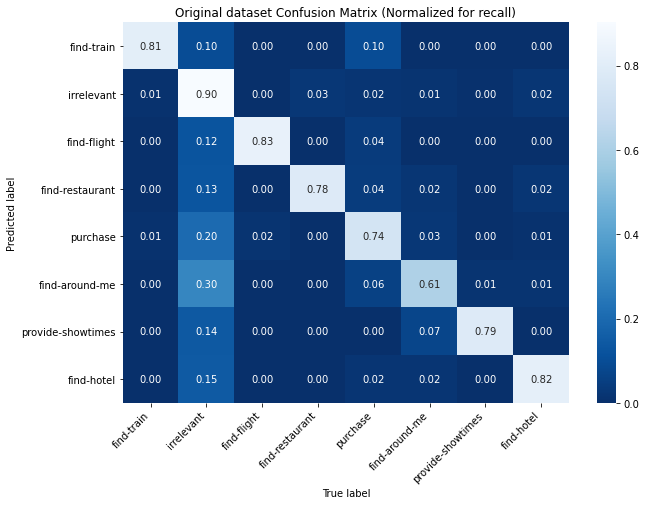

In [84]:
cm_testing_metrics = np.array(cm, dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, title="Original dataset Confusion Matrix (Normalized for recall)", fmt=".2f")

In [86]:
print(report_t[0])

                   precision    recall  f1-score   support

   find-around-me       0.97      0.97      0.97       383
      find-flight       0.99      0.98      0.98       142
       find-hotel       0.97      0.99      0.98       316
  find-restaurant       0.97      0.98      0.98       469
       find-train       0.95      0.99      0.97       143
       irrelevant       1.00      0.99      0.99      3852
provide-showtimes       0.91      0.99      0.95       117
         purchase       0.98      0.98      0.98       613

         accuracy                           0.99      6035
        macro avg       0.97      0.98      0.98      6035
     weighted avg       0.99      0.99      0.99      6035



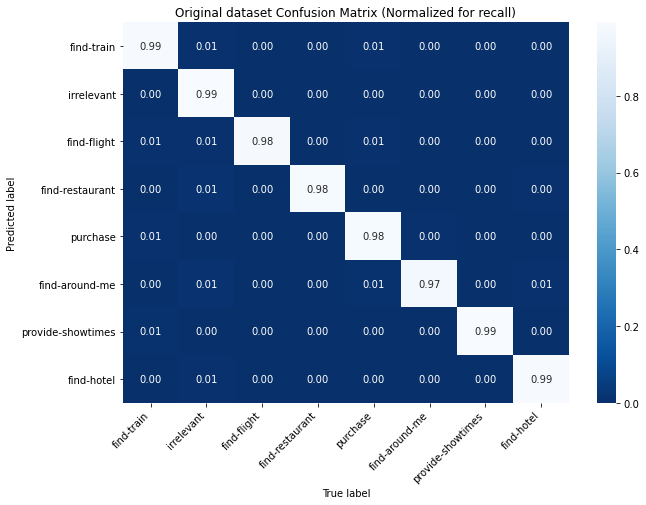

In [87]:
cm_testing_metrics = np.array(cm_t, dtype='float64')
for i in range(len(cm_testing_metrics)):
    cm_testing_metrics[i] = cm_testing_metrics[i] / np.sum(cm_testing_metrics[i])
plot_confusion_matrix(cm_testing_metrics, title="Original dataset Confusion Matrix (Normalized for recall)", fmt=".2f")